# Capstone Project: Mask Wearing Detector

---


## Table of Contents

1. Introduction
2. Problem Statement
3. EDA

---

## Introduction

The COVID-19 pandemic is an ongoing global pandemic caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). Currently [evidence](https://www.cdc.gov/coronavirus/2019-ncov/science/science-briefs/sars-cov-2-transmission.html) suggest that the transmission of COVID-19 is primary through respiratory droplets which can be expelled through coughs, sneezes, talks etc. As such, effective ways of inhibiting the spread of the virus is through wearing of surgical mask at public spaces. Mask wearing will reduce transmission both from inhalation of virus and deposition of virus on exposed membranes.  

Countries around the world have made mask-wearing mandatory in public area as part of the measure to curb the the spread of COVID-19. Resources are poured to ensure compliance and enforcement of this rule. 


## Problem Statement

Instead of deploying human resources to conduce mask-wearing compliance check or enforcement, they can be re-deployed to assist front line workers to manage the pandemic (e.g. health care workers etc). This project will explore using computer vision and deep learning for mask-wearing compliance.

The problem to tackle falls under the subset of object detection problem in the machine vision domain. Specifically, this is a supervised classification problem where model is required to classify if a person is (1) wearing mask, (2) not wearing mask, or (3) not wearing mask correctly. 

---

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import cv2
import glob
import math
import lxml.etree as etree 
from xml.etree import ElementTree
# from sklearn.model_selection import train_test_split

# from google.colab import drive   #if using colab

# import tensorflow as tf
# from tensorflow import keras
# from keras.preprocessing.image import (
#     ImageDataGenerator,
#     img_to_array,
#     load_img,
# )

In [2]:
# print("Tensorflow Version: {}".format(tf.__version__))
# print(tf.test.gpu_device_name())
# print(
#     "Num GPUs Available: ",
#     len(tf.config.experimental.list_physical_devices("GPU")),
# )

In [3]:
# if using colab

# drive.mount('/content/gdrive')
# !unzip -q /content/gdrive/MyDrive/capstone_data/archive.zip -d /content/input_data
# print('import completed')

## Image Dataset

As this project is a supervised classification problem, sufficient label image data is required for training. Fortunately, a Kaggle user has shared this dataset online and can be downloaded through this [link](https://www.kaggle.com/andrewmvd/face-mask-detection).

The author has kindly provided 853 labelled image and annotation files. 


In [4]:
# unzip the kaggle dataset
!unzip -q -o ../input_data/archive.zip -d ../input_data/
print("unzip completed")

unzip completed


In [5]:
# define path
IMGS_PATH = "../input_data/images/"
ANNOT_PATH = "../input_data/annotations/"
CROPPED_PATH = "../output_data/cropped_images/"
CSV_PATH = "../output_data/csv/"

In [6]:
# save the images and annotation files as a sorted list
imgs_list = sorted(os.listdir(IMGS_PATH))
annot_list = sorted(os.listdir(ANNOT_PATH))

# check list
print(f"first 3 items in imgs list: {imgs_list[:3]}")
print(f"first 3 items in annot list: {annot_list[:3]}")

first 3 items in imgs list: ['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png']
first 3 items in annot list: ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml']


In [7]:
# check number of files
print(f"Number of image files: {len(imgs_list)}")
print(f"Number of annotation files:  {len(annot_list)}")

Number of image files: 853
Number of annotation files:  853


## EDA

In this section, images and annotation files will be examined.

### Annotation Files

From printed annotation file below e.g. `maksssksksss0.xml`, it can be confirmed that the author of the data has chosen to use Pascal VOC format to label the images.In this annotation file there are information on: 

- **image size**: the image file is 512 (width) by 366 (height) with 3 colour channels 
- **location of bounding boxes**: 3 bounding boxes described by x_min, x_max, y_min, y_max
- **class**: classes of each bounded boxes (e.g. with_mask, without_mask)

Bounding boxes refers to a rectangular label that describe the object's location in the image. They can be described by the coordinates of vertices in rectangle or the centre point of the x, y coordinate with a combination of height and width information. 

In [8]:
# Check annotation file
x = etree.parse(ANNOT_PATH + annot_list[0])
print(" file content of maksssksksss0.xml ".center(50, "="))
print(etree.tostring(x, encoding="unicode", pretty_print=True))

======= file content of maksssksksss0.xml ========
<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
     

### Image Files

The images data provides comes in different format (e.g. landscape, portrait) and different sizes. Interesting enough, the author of the images set has provided variety of angles of a person wearing a mask. This will be useful to generalise our model and to identify a person wearing a mask. 

In [9]:
# define function
def show_img(img_name):
    img_name = IMGS_PATH + img_name
    img_arr = cv2.imread(img_name)
    # cv2 reads image and store in BGR, while matplotlib reads in RGB
    # cv2.cvtColor will convert in to correct channel format
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_arr)
    return


def show_more_img(img_name_list):
    path_lst = [IMGS_PATH + img_file for img_file in img_name_list]
    nrow = len(path_lst)
    figsize = (10, 5 * nrow)
    fig, ax = plt.subplots(
        nrows=nrow, ncols=1, figsize=figsize, constrained_layout=True
    )

    for i in range(nrow):
        img_arr = cv2.imread(path_lst[i])
        # cv2 reads image and store in BGR, while matplotlib reads in RGB
        # cv2.cvtColor will convert in to correct channel format
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img_arr)

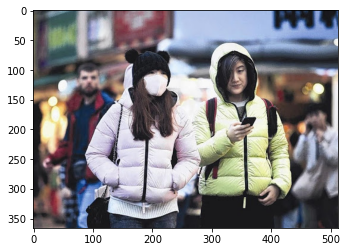

In [10]:
# Check image file
show_img(imgs_list[0])

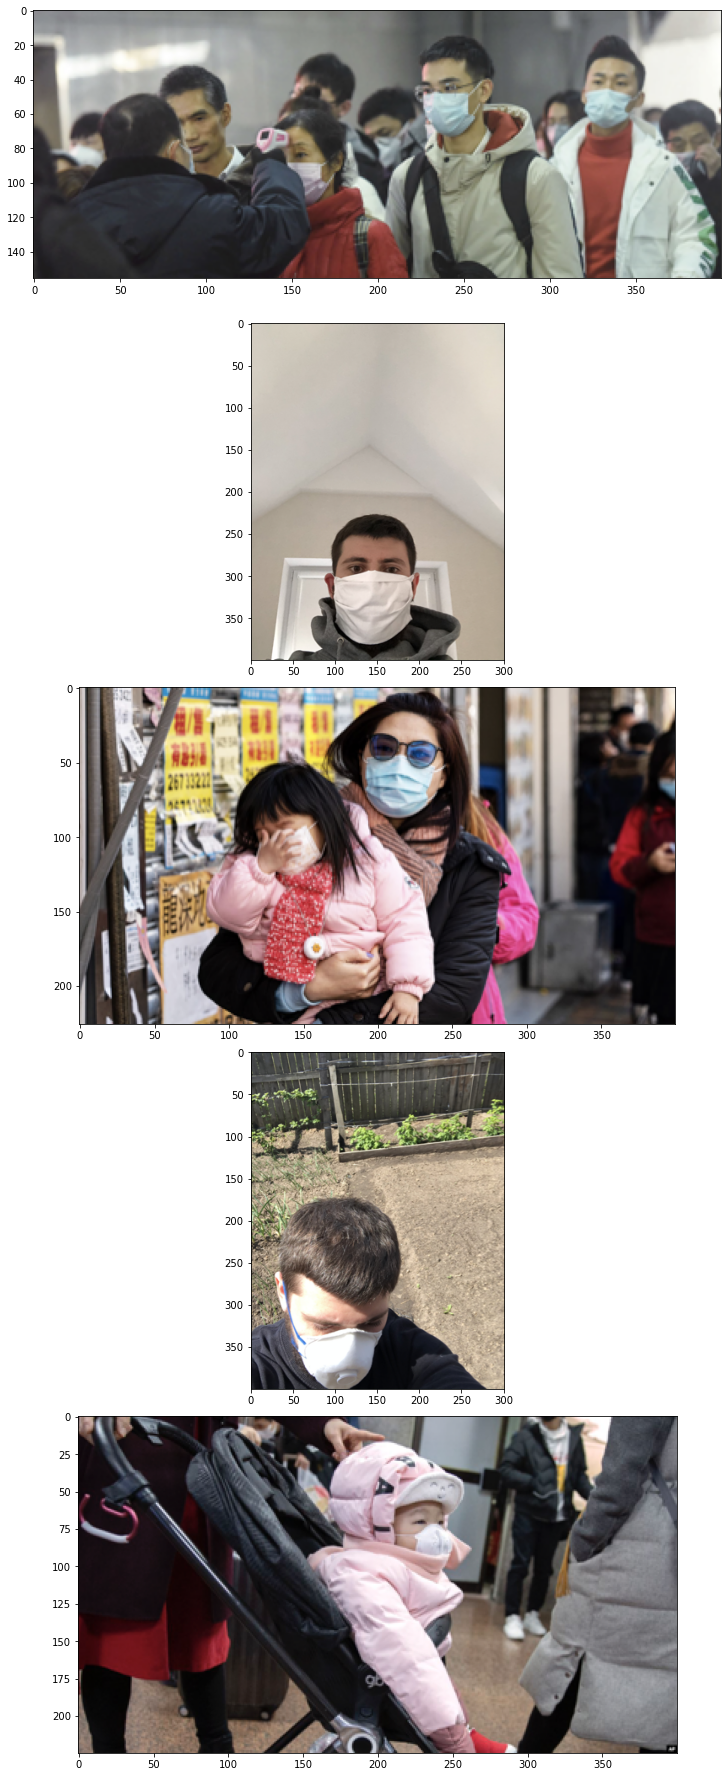

In [11]:
# Check more images
show_more_img(imgs_list[1:6])

In [12]:
# extracting information and save into dictionary
information = {
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
    "label": [],
    "width": [],
    "height": [],
    "images": [],
}

for annotation in glob.glob(ANNOT_PATH + "*.xml"):
    tree = ElementTree.parse(annotation)

    for element in tree.iter():
        if "filename" in element.tag:
            filename = element.text

        if "size" in element.tag:
            for attribute in list(element):
                if "width" in attribute.tag:
                    width = int(attribute.text)
                if "height" in attribute.tag:
                    height = int(attribute.text)

        if "object" in element.tag:
            for attribute in list(element):

                if "name" in attribute.tag:
                    name = attribute.text
                    information["label"] += [name]
                    information["width"] += [width]
                    information["height"] += [height]
                    information["images"] += [filename]

                if "bndbox" in attribute.tag:
                    for value in list(attribute):
                        if "xmin" in value.tag:
                            xmin = int(value.text)
                            information["xmin"] += [xmin]
                        if "ymin" in value.tag:
                            ymin = int((value.text))
                            information["ymin"] += [ymin]
                        if "xmax" in value.tag:
                            xmax = int((value.text))
                            information["xmax"] += [xmax]
                        if "ymax" in value.tag:
                            ymax = int((value.text))
                            information["ymax"] += [ymax]

In [13]:
# save in dataframe
df = pd.DataFrame(information)
df["annotation"] = df["images"].apply(lambda x: x.split(".")[0] + ".xml")
df = df.sort_values("images").reset_index(drop=True)

In [14]:
# print dataframe
df.head()

,xmin,ymin,xmax,ymax,label,width,height,images,annotation
0,185,100,226,144,with_mask,512,366,maksssksksss0.png,maksssksksss0.xml
1,79,105,109,142,without_mask,512,366,maksssksksss0.png,maksssksksss0.xml
2,325,90,360,141,without_mask,512,366,maksssksksss0.png,maksssksksss0.xml
3,369,70,398,99,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml
4,21,73,44,93,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml


In [15]:
# function to cropped faces based on bounding boxes
def cropping(df):
    os.makedirs(CROPPED_PATH, exist_ok=True)
    for i in range(len(df)):
        img_path = IMGS_PATH + df["images"].iloc[i]
        img_arr = cv2.imread(img_path)
        cropped_image = re.sub(
            "\.(?<=\.).+", "-" + str(i), df["images"].iloc[i]
        )

        xmin = df["xmin"].iloc[i]
        ymin = df["ymin"].iloc[i]
        xmax = df["xmax"].iloc[i]
        ymax = df["ymax"].iloc[i]

        cropped_arr = img_arr[ymin:ymax, xmin:xmax]
        cropped_img_path = CROPPED_PATH + cropped_image + ".png"
        cv2.imwrite(cropped_img_path, cropped_arr)

In [16]:
# run function
cropping(df)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [17]:
# update dataframe with cropped images
df["cropped_images"] = df.apply(
    lambda row: re.sub(
        "\.(?<=\.).+", "-" + str(row.name) + ".png", row["images"]
    ),
    axis=1,
)

In [18]:
# check dataframe
display(df.head(10))
display(df.tail(10))

,xmin,ymin,xmax,ymax,label,width,height,images,annotation,cropped_images
0,185,100,226,144,with_mask,512,366,maksssksksss0.png,maksssksksss0.xml,maksssksksss0-0.png
1,79,105,109,142,without_mask,512,366,maksssksksss0.png,maksssksksss0.xml,maksssksksss0-1.png
2,325,90,360,141,without_mask,512,366,maksssksksss0.png,maksssksksss0.xml,maksssksksss0-2.png
3,369,70,398,99,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-3.png
4,21,73,44,93,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-4.png
5,191,67,221,93,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-5.png
6,83,56,111,89,without_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-6.png
7,143,74,174,115,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-7.png
8,299,58,315,81,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-8.png
9,224,38,261,73,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-9.png


,xmin,ymin,xmax,ymax,label,width,height,images,annotation,cropped_images
4062,102,97,140,135,with_mask,400,280,maksssksksss96.png,maksssksksss96.xml,maksssksksss96-4062.png
4063,251,88,282,124,without_mask,400,280,maksssksksss96.png,maksssksksss96.xml,maksssksksss96-4063.png
4064,187,83,212,109,with_mask,301,400,maksssksksss97.png,maksssksksss97.xml,maksssksksss97-4064.png
4065,41,73,65,95,with_mask,400,267,maksssksksss98.png,maksssksksss98.xml,maksssksksss98-4065.png
4066,344,80,377,106,with_mask,400,267,maksssksksss98.png,maksssksksss98.xml,maksssksksss98-4066.png
4067,263,62,287,85,with_mask,400,267,maksssksksss98.png,maksssksksss98.xml,maksssksksss98-4067.png
4068,196,43,236,91,with_mask,400,267,maksssksksss98.png,maksssksksss98.xml,maksssksksss98-4068.png
4069,99,87,176,165,with_mask,400,267,maksssksksss99.png,maksssksksss99.xml,maksssksksss99-4069.png
4070,181,54,273,162,mask_weared_incorrect,400,267,maksssksksss99.png,maksssksksss99.xml,maksssksksss99-4070.png
4071,289,99,355,233,with_mask,400,267,maksssksksss99.png,maksssksksss99.xml,maksssksksss99-4071.png


In [19]:
# check cropping - quantity should be the same
print(f"length of dataframe: {len(df)}")
print(f"number of cropped images: {len(os.listdir(CROPPED_PATH))}")

length of dataframe: 4072
number of cropped images: 4072


### Image distribution

From the plots and summary statistics:

Bounding boxes:
- left skewed distribution for both height and width
- average width and height were 31px and 35px

Image size:
- distribution of image width concentrated on 400px, while image height has bimodal distribution (peak at 400px and 260px)
- average width and height were 31px and 35px


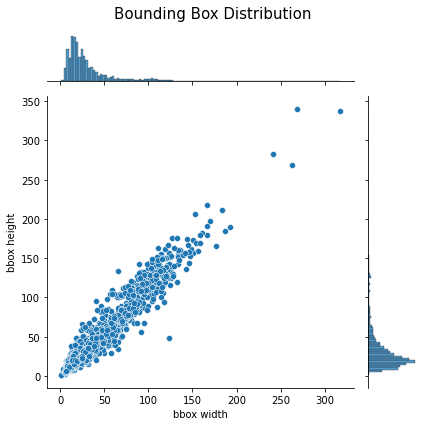

In [20]:
# plot distribution of the bounding boxes
plot = sns.jointplot(x=(df.xmax - df.xmin), y=(df.ymax - df.ymin))
plot.set_axis_labels("bbox width", "bbox height")
plot.fig.suptitle("Bounding Box Distribution", fontsize=15)
plt.tight_layout()

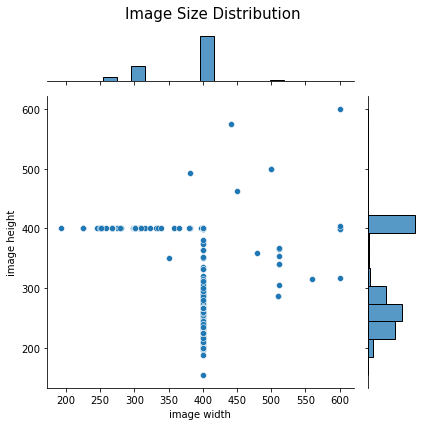

In [21]:
# plot distribution of image size
plot = sns.jointplot(
    x=df.groupby("images").mean()["width"],
    y=df.groupby("images").mean()["height"],
)
plot.set_axis_labels("image width", "image height")
plot.fig.suptitle("Image Size Distribution", fontsize=15)
plt.tight_layout()

In [22]:
# print out mean and median
print(" Bounding boxe statistics ".center(50, "="))
print(f"average width : {(df.xmax - df.xmin).mean()}")
print(f"average height: {(df.ymax - df.ymin).mean()}")
print(f"median width : {(df.xmax - df.xmin).median()}")
print(f"median height: {(df.ymax - df.ymin).median()}")
print("")
print(" Image statistics ".center(50, "="))
print(f"average width : {df.groupby('images').mean()['width'].mean()}")
print(f"average height: {df.groupby('images').mean()['height'].mean()}")
print(f"median width : {df.groupby('images').mean()['height'].median()}")
print(f"median height: {df.groupby('images').mean()['height'].median()}")

============ Bounding boxe statistics ============
average width : 31.149066797642437
average height: 35.0049115913556
median width : 22.0
median height: 24.0

================ Image statistics ================
average width : 370.5896834701055
average height: 309.28956623681125
median width : 280.0
median height: 280.0


### Class Distribution

Our training image data is not balanced. Among the cropped images, 79% are wearing masked, 18% are not wearing masked, and only 3% are wearing it incorrectly.

In [23]:
# check class distribution
df.label.value_counts(normalize=True)

with_mask                0.793713
without_mask             0.176081
mask_weared_incorrect    0.030206
Name: label, dtype: float64

## Save Data

The results are saved and prepared for modelling in Google Colab.

In [24]:
# zip cropped images into output folder
!zip -r -q output_data/cropped_images.zip output_data/cropped_images/


zip error: Nothing to do! (try: zip -r -q output_data/cropped_images.zip . -i output_data/cropped_images/)


In [25]:
# save dataframe as csv
os.makedirs(CSV_PATH, exist_ok=True)
df.to_csv(CSV_PATH + "mask.csv", index=False)